
# Oxford 102 Flowers — Pipeline completo de entrenamiento (PyTorch)

Este notebook entrena un modelo de **clasificación de imágenes** usando el dataset **Oxford 102 Flowers**.

✅ La carpeta con datos estará en la raíz del ambiente y se llamará **`imgs/`**.

Este pipeline soporta automáticamente dos formatos comunes:

### A) Formato `ImageFolder` (recomendado)
```
imgs/
  class_001/
    xxx.jpg
  class_002/
    yyy.jpg
  ...
```

### B) Formato oficial Oxford (+ archivos .mat)
```
imgs/
  jpg/
    image_00001.jpg
    ...
  imagelabels.mat
  setid.mat
```



## 0) Instalación de dependencias (si hace falta)

Si ya tienes PyTorch instalado, puedes saltarte esta celda.


In [1]:

# Si estás en Google Colab o no tienes torch/torchvision, descomenta:
# !pip -q install torch torchvision torchaudio
# !pip -q install matplotlib scikit-learn tqdm scipy


## 1) Imports, configuración y utilidades

In [2]:

import os
import random
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Solo se usa si detectamos formato Oxford oficial (.mat)
try:
    import scipy.io as sio
except Exception as e:
    sio = None
    print("⚠️ scipy no está disponible. Si tu dataset es el formato Oxford oficial (.mat), instala scipy:", e)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


/Users/puac/Documents/programming/flowers_classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

## 2) Parámetros del experimento

In [3]:

# Ruta base (según lo que pediste)
DATA_DIR = Path("imgs")

# Hiperparámetros principales
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0
EPOCHS = 12
LR = 3e-4
WEIGHT_DECAY = 1e-4

# Early stopping
PATIENCE = 4

# Modelo backbone (elige uno)
BACKBONE = "efficientnet_b0"  # opciones: "resnet50", "efficientnet_b0", "mobilenet_v3_large"

print("DATA_DIR:", DATA_DIR.resolve())


DATA_DIR: /Users/puac/Documents/programming/flowers_classification/imgs


## 3) Detección del formato del dataset y carga de datos

In [4]:

def detect_dataset_mode(data_dir: Path):
    """
    Devuelve 'imagefolder' si detecta subcarpetas de clases,
    o 'oxford_mat' si detecta imagelabels.mat / setid.mat.
    """
    if not data_dir.exists():
        raise FileNotFoundError(f"No existe la ruta {data_dir}. Crea la carpeta 'imgs' en la raíz del ambiente.")

    # 1) Oxford oficial con mats
    has_labels_mat = (data_dir / "imagelabels.mat").exists()
    has_setid_mat = (data_dir / "setid.mat").exists()
    has_jpg_folder = (data_dir / "jpg").exists()

    if has_labels_mat and has_setid_mat and has_jpg_folder:
        return "oxford_mat"

    # 2) ImageFolder: subcarpetas con imágenes dentro
    subdirs = [p for p in data_dir.iterdir() if p.is_dir() and not p.name.startswith(".")]
    if len(subdirs) >= 2:
        return "imagefolder"

    # Caso ambiguo
    img_files = list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.png")) + list(data_dir.glob("*.jpeg"))
    if len(img_files) > 50 and (has_labels_mat and has_setid_mat):
        return "oxford_mat"
    if len(img_files) > 50:
        raise RuntimeError(
            "Detecté muchas imágenes sueltas en imgs/, pero no encontré etiquetas/splits (.mat) "
            "ni carpetas por clase. Para clasificación supervisada necesitas una de esas dos estructuras."
        )

    raise RuntimeError(
        "No pude detectar el formato. Asegúrate de tener:\n"
        "A) imgs/<clase>/... (ImageFolder) o\n"
        "B) imgs/jpg/*.jpg + imgs/imagelabels.mat + imgs/setid.mat (Oxford oficial)."
    )

mode = detect_dataset_mode(DATA_DIR)
print("✅ Modo detectado:", mode)


✅ Modo detectado: oxford_mat


## 4) Transforms y creación de datasets/dataloaders

In [5]:

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class OxfordMatDataset(Dataset):
    """
    Dataset para Oxford 102 oficial:
    - imgs/jpg/image_00001.jpg ... image_08189.jpg
    - imgs/imagelabels.mat (labels 1..102)
    - imgs/setid.mat (splits: trnid, valid, tstid)
    """
    def __init__(self, data_dir: Path, indices: np.ndarray, transform=None):
        if sio is None:
            raise ImportError("scipy no está instalado. Instala scipy para leer .mat.")
        self.data_dir = data_dir
        self.transform = transform

        labels_mat = sio.loadmat(str(data_dir / "imagelabels.mat"))
        self.labels = labels_mat["labels"].squeeze().astype(np.int64)  # 1..102

        self.jpg_dir = data_dir / "jpg"
        self.indices = indices.astype(np.int64)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = int(self.indices[i])  # 1-based
        img_path = self.jpg_dir / f"image_{idx:05d}.jpg"
        y = int(self.labels[idx - 1]) - 1  # 0..101

        from PIL import Image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y

def build_dataloaders(data_dir: Path, mode: str):
    if mode == "imagefolder":
        full_train = datasets.ImageFolder(root=str(data_dir), transform=train_tfms)
        full_val = datasets.ImageFolder(root=str(data_dir), transform=val_tfms)

        n = len(full_train)
        idxs = np.random.permutation(n)
        n_train = int(0.8 * n)
        n_val = int(0.1 * n)
        train_idx = idxs[:n_train]
        val_idx = idxs[n_train:n_train+n_val]
        test_idx = idxs[n_train+n_val:]

        train_ds = Subset(full_train, train_idx)
        val_ds = Subset(full_val, val_idx)
        test_ds = Subset(full_val, test_idx)

        class_names = full_train.classes
        num_classes = len(class_names)

    elif mode == "oxford_mat":
        setid_mat = sio.loadmat(str(data_dir / "setid.mat"))
        trn = setid_mat["trnid"].squeeze()
        val = setid_mat["valid"].squeeze()
        tst = setid_mat["tstid"].squeeze()

        train_ds = OxfordMatDataset(data_dir, trn, transform=train_tfms)
        val_ds = OxfordMatDataset(data_dir, val, transform=val_tfms)
        test_ds = OxfordMatDataset(data_dir, tst, transform=val_tfms)

        num_classes = 102
        class_names = [f"class_{i:03d}" for i in range(num_classes)]

    else:
        raise ValueError("Modo no soportado")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    return train_loader, val_loader, test_loader, class_names, num_classes

train_loader, val_loader, test_loader, class_names, num_classes = build_dataloaders(DATA_DIR, mode)

print("✅ Classes:", num_classes)
print("Train batches:", len(train_loader), "Val batches:", len(val_loader), "Test batches:", len(test_loader))


✅ Classes: 102
Train batches: 32 Val batches: 32 Test batches: 193


## 5) Visualización rápida de datos

In [6]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return img_tensor.cpu() * std + mean


/Users/puac/Documents/programming/flowers_classification/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


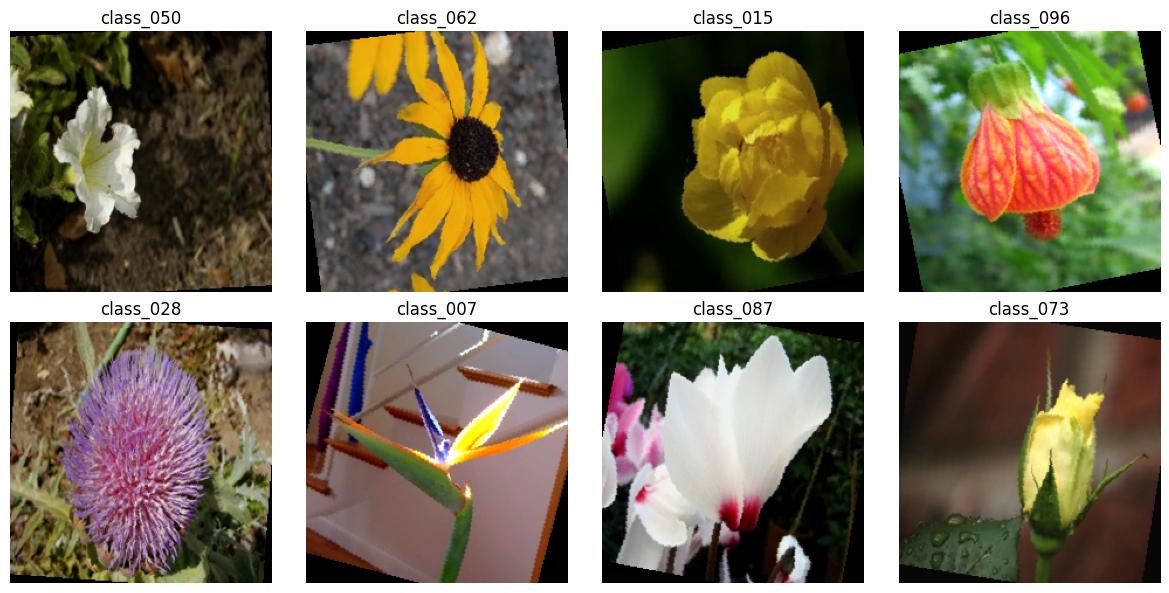

In [7]:
images, labels = next(iter(train_loader))
images, labels = images[:8], labels[:8]

plt.figure(figsize=(12, 6))
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    plt.imshow(denormalize(images[i]).permute(1,2,0).clamp(0,1))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 6) Modelo (transfer learning) + criterio + optimizador

In [9]:

def build_model(backbone: str, num_classes: int):
    if backbone == "resnet50":
        model = models.resnet50(weights=None)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    elif backbone == "efficientnet_b0":
        model = models.efficientnet_b0(weights=None)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    elif backbone == "mobilenet_v3_large":
        model = models.mobilenet_v3_large(weights=None)
        in_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(in_features, num_classes)

    else:
        raise ValueError("Backbone no soportado")

    return model

model = build_model(BACKBONE, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

print("Params (M):", sum(p.numel() for p in model.parameters()) / 1e6)


Params (M): 4.13821


/var/folders/1h/j5y0_9x15117ttkx77byfgwh0000gn/T/ipykernel_46262/1293087489.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


## 7) Loop de entrenamiento con Early Stopping (guardando el mejor modelo)

In [10]:

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def run_one_epoch(model, loader, train: bool):
    model.train() if train else model.eval()

    epoch_loss = 0.0
    epoch_acc = 0.0
    n_batches = 0

    pbar = tqdm(loader, desc=("train" if train else "val"), leave=False)
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.set_grad_enabled(train):
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        acc = accuracy_from_logits(logits, y)
        epoch_loss += loss.item()
        epoch_acc += acc
        n_batches += 1
        pbar.set_postfix(loss=loss.item(), acc=acc)

    return epoch_loss / max(n_batches, 1), epoch_acc / max(n_batches, 1)

best_val_loss = float("inf")
best_path = Path("best_model.pt")
patience_left = PATIENCE

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss, train_acc = run_one_epoch(model, train_loader, train=True)
    val_loss, val_acc = run_one_epoch(model, val_loader, train=False)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f} | {dt:.1f}s")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        patience_left = PATIENCE
        torch.save({
            "model": model.state_dict(),
            "backbone": BACKBONE,
            "img_size": IMG_SIZE,
            "class_names": class_names
        }, best_path)
        print(f"✅ Guardado mejor modelo en: {best_path} (val_loss={best_val_loss:.4f})")
    else:
        patience_left -= 1
        if patience_left <= 0:
            print("🛑 Early stopping: no mejora en validación.")
            break

print("Best val loss:", best_val_loss)


train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/1h/j5y0_9x15117ttkx77byfgwh0000gn/T/ipykernel_46262/1723866918.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 01/12 | train loss 4.6903 acc 0.0107 | val loss 4.6338 acc 0.0098 | 261.6s
✅ Guardado mejor modelo en: best_model.pt (val_loss=4.6338)


Epoch 02/12 | train loss 4.5257 acc 0.0186 | val loss 4.6592 acc 0.0098 | 254.5s


Epoch 03/12 | train loss 4.3626 acc 0.0187 | val loss 4.2815 acc 0.0518 | 254.6s
✅ Guardado mejor modelo en: best_model.pt (val_loss=4.2815)


Epoch 04/12 | train loss 4.1550 acc 0.0325 | val loss 4.2066 acc 0.0658 | 254.3s
✅ Guardado mejor modelo en: best_model.pt (val_loss=4.2066)


Epoch 05/12 | train loss 3.9742 acc 0.0501 | val loss 3.8959 acc 0.0893 | 258.9s
✅ Guardado mejor modelo en: best_model.pt (val_loss=3.8959)


Epoch 06/12 | train loss 3.8285 acc 0.0636 | val loss 3.6896 acc 0.1116 | 253.9s
✅ Guardado mejor modelo en: best_model.pt (val_loss=3.6896)


Epoch 07/12 | train loss 3.6972 acc 0.1085 | val loss 3.5819 acc 0.1232 | 269.3s
✅ Guardado mejor modelo en: best_model.pt (val_loss=3.5819)


Epoch 08/12 | train loss 3.5288 acc 0.1274 | val loss 3.4688 acc 0.1547 | 268.4s
✅ Guardado mejor modelo en: best_model.pt (val_loss=3.4688)


Epoch 09/12 | train loss 3.4446 acc 0.1441 | val loss 3.3668 acc 0.1653 | 267.7s
✅ Guardado mejor modelo en: best_model.pt (val_loss=3.3668)


Epoch 10/12 | train loss 3.3751 acc 0.1431 | val loss 3.3216 acc 0.1733 | 273.3s
✅ Guardado mejor modelo en: best_model.pt (val_loss=3.3216)


Epoch 11/12 | train loss 3.3116 acc 0.1695 | val loss 3.3099 acc 0.1769 | 263.9s
✅ Guardado mejor modelo en: best_model.pt (val_loss=3.3099)


Epoch 12/12 | train loss 3.3070 acc 0.1804 | val loss 3.2946 acc 0.1765 | 266.2s
✅ Guardado mejor modelo en: best_model.pt (val_loss=3.2946)
Best val loss: 3.2946231178939342


## 8) Curvas de entrenamiento

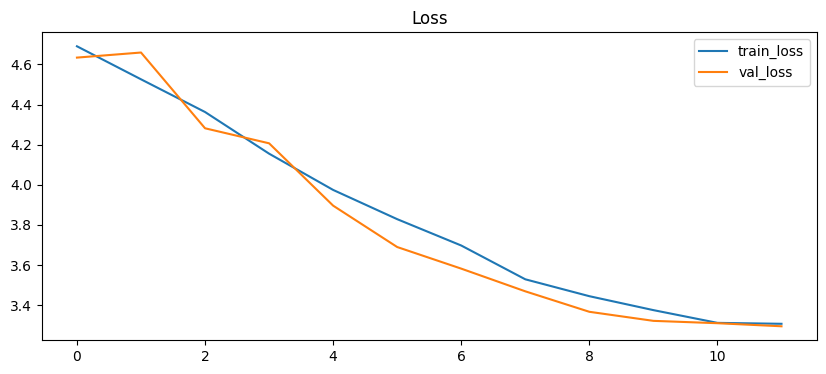

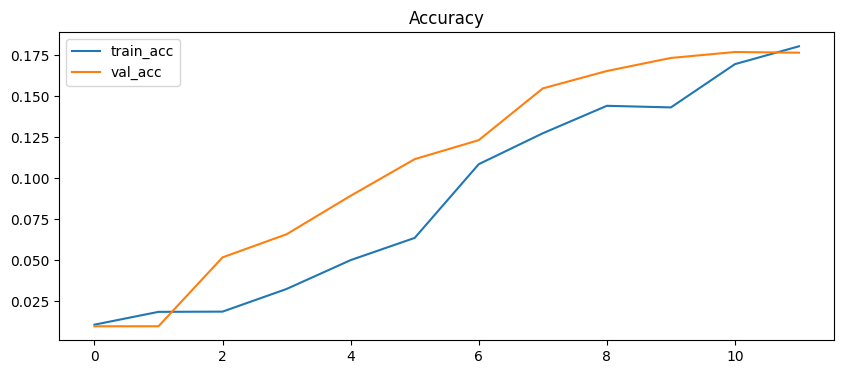

In [11]:

plt.figure(figsize=(10,4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()


## 9) Evaluación en test: métricas + matriz de confusión

test: 100%|██████████| 193/193 [04:34<00:00,  1.42s/it]

✅ Classification report:
              precision    recall  f1-score   support

   class_000       0.02      0.10      0.03        20
   class_001       0.00      0.00      0.00        40
   class_002       0.00      0.00      0.00        20
   class_003       0.00      0.00      0.00        36
   class_004       0.15      0.40      0.21        45
   class_005       0.18      0.24      0.21        25
   class_006       0.00      0.00      0.00        20
   class_007       0.59      0.35      0.44        65
   class_008       0.16      0.19      0.18        26
   class_009       0.15      0.40      0.22        25
   class_010       0.00      0.00      0.00        67
   class_011       0.26      0.24      0.25        67
   class_012       0.07      0.07      0.07        29
   class_013       0.11      0.11      0.11        28
   class_014       0.06      0.28      0.10        29
   class_015       0.01      0.05      0.02        21
   class_016       1.00      0.02      0.03        65
  

<Figure size 1000x1000 with 0 Axes>

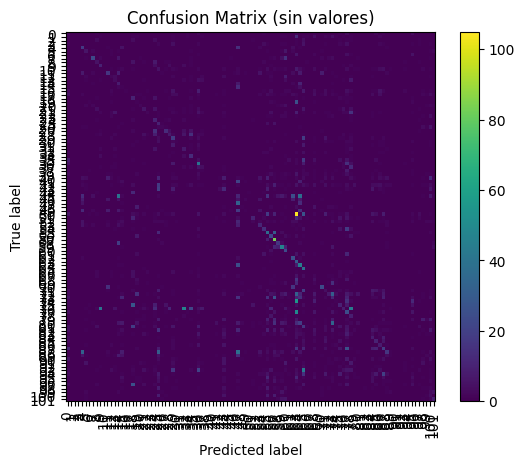

In [12]:

ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

all_preds, all_true = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="test"):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

print("✅ Classification report:")
print(classification_report(all_true, all_preds, target_names=class_names, zero_division=0))

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(10,10))
disp.plot(include_values=False, xticks_rotation="vertical")
plt.title("Confusion Matrix (sin valores)")
plt.show()


## 10) Inferencia rápida (opcional)

In [20]:
import json

with open("cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

In [21]:
def decode_predictions(preds, cat_to_name):
    decoded = []
    for cls, prob in preds:
        # "class_078" -> "78"
        class_id = str(int(cls.split("_")[1]))
        flower_name = cat_to_name.get(class_id, cls)
        decoded.append((flower_name, prob))
    return decoded

In [37]:

from PIL import Image

def predict_image(path: str, topk: int = 5):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

    top_idx = np.argsort(-probs)[:topk]

    results = []
    for i in top_idx:
        # i es índice 0..101 → Oxford es 1..102
        oxford_id = i + 1
        flower_name = cat_to_name[str(oxford_id)]
        results.append((flower_name, float(probs[i])))

    return results

def predict_image_ids(path, topk=5):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        probs = torch.softmax(model(x), dim=1).squeeze(0).cpu().numpy()
    top_idx = np.argsort(-probs)[:topk]
    return [(int(i)+1, float(probs[i])) for i in top_idx]  # ID Oxford 1..102

# Ejemplo:
predict_image_ids("imgs/jpg/image_00543.jpg", topk=5)
predict_image("imgs/jpg/image_00543.jpg", topk=5)


[('lotus', 0.10329629480838776),
 ('silverbush', 0.05462361127138138),
 ('siam tulip', 0.051836710423231125),
 ('windflower', 0.04678419604897499),
 ('pelargonium', 0.04529629275202751)]

In [30]:
print("77 ->", cat_to_name["77"])
print("78 ->", cat_to_name["78"])
print("79 ->", cat_to_name["79"])

77 -> passion flower
78 -> lotus
79 -> toad lily



## 11) Export / guardado final

El mejor modelo queda en `best_model.pt` con:
- `state_dict` (pesos)
- backbone usado
- tamaño de imagen
- nombres de clases


In [38]:
best_path.resolve()

PosixPath('/Users/puac/Documents/programming/flowers_classification/best_model.pt')

In [39]:
torch.save({"model_state_dict": model.state_dict()}, "best_model.pt")